In [19]:
# pycaretをimport
from pycaret.classification import *
from pycaret.regression import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

import japanize_matplotlib  # 日本語化ライブラリをインポート

# 日本語フォントを設定
plt.rcParams['font.family'] = 'IPAexGothic'

from utils import *

def list_functions():
    with open('utils.py', 'r') as file:
        lines = file.readlines()
        for line in lines:
            if 'def ' in line:
                function_name = line.split('def ')[1].split('(')[0]
                print(function_name)

list_functions()

get_arrangement
convert_era_to_year
plot_feature_and_price


### データの読み込み

In [34]:
# ./train/train/*.csvを読み込み、train_dfに格納
train_df = pd.DataFrame()
for file in os.listdir('./train/'):
    train_df = pd.concat([train_df, pd.read_csv('./train/' + file)], axis=0)

# indexを振り直す
train_df = train_df.reset_index(drop=True)

# nanだけを含む特徴量を削除
for column in train_df.columns.to_list():
    if train_df[column].isnull().sum() == len(train_df):
        train_df = train_df.drop(column, axis=1)

# object型で値が一つしかない特徴量を削除
for column in train_df.columns.to_list():
    if train_df[column].dtype == 'object':
        if len(train_df[column].unique()) == 1:
            train_df = train_df.drop(column, axis=1)

# ID、市区町村コード、都道府県名を削除
train_df = train_df.drop(['ID', '市区町村名', '今後の利用目的'], axis=1)

columns = train_df.columns.to_list()
features = columns[:-1]
target = columns[-1]

for i in range(len(columns)):
    print(columns[i], ":", train_df[columns[i]].dtype)
        

市区町村コード : int64
都道府県名 : object
地区名 : object
最寄駅：名称 : object
最寄駅：距離（分） : object
間取り : object
面積（㎡） : object
建築年 : object
建物の構造 : object
用途 : object
都市計画 : object
建ぺい率（％） : float64
容積率（％） : float64
取引時点 : object
改装 : object
取引の事情等 : object
取引価格（総額）_log : float64


## 前処理

### 間取りを['部屋タイプ', '部屋数', 'サービスルーム', 'キッチン']に変換

In [3]:
train_df[['部屋タイプ', '部屋数', 'サービスルーム', 'キッチン']] = train_df['間取り'].apply(get_arrangement).apply(pd.Series)
train_df = train_df.drop('間取り', axis=1)
train_df.head()

,最寄駅：名称,最寄駅：距離（分）,面積（㎡）,建築年,建物の構造,用途,今後の利用目的,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引の事情等,取引価格（総額）_log,部屋タイプ,部屋数,サービスルーム,キッチン
0,福大前,14,65,平成9年,ＲＣ,住宅,住宅,第２種住居地域,60.0,200.0,2022年第1四半期,未改装,調停・競売等,7.079181,LDK,2.0,0.0,0.0
1,西鉄久留米,7,75,平成14年,ＳＲＣ,住宅,住宅,商業地域,80.0,400.0,2016年第1四半期,未改装,NaN,7.255273,LDK,3.0,0.0,0.0
2,別府(福岡),3,60,平成5年,ＲＣ,住宅,NaN,第１種住居地域,60.0,200.0,2008年第4四半期,未改装,NaN,7.146128,LDK,2.0,0.0,0.0
3,花畑,13,60,昭和64年,ＳＲＣ,住宅,住宅,第１種住居地域,60.0,200.0,2016年第4四半期,未改装,NaN,7.000000,LDK,3.0,0.0,0.0
4,西新,16,55,昭和61年,ＲＣ,住宅,住宅,第１種住居地域,60.0,200.0,2020年第3四半期,未改装,NaN,7.079181,LDK,2.0,0.0,0.0


### 建築年を西暦に変換

In [4]:
# train_df['建築年']の要素がnanでなく、かつ"戦前"で始まる場合は、"昭和10年"に変換
train_df['建築年'] = train_df['建築年'].apply(lambda x: "昭和10年" if x == "戦前" else x)

# convert_era_to_yearで築年数を西暦に変換した後、2023年を基準にして何年前かを表す特徴量を作成
train_df['築年数'] = train_df['建築年'].apply(convert_era_to_year)
train_df['築年数'] = 2023 - train_df['築年数']
train_df = train_df.drop('建築年', axis=1)


In [5]:
## 建ぺい率（％） : float64, 容積率（％） : float64をlog変換
train_df['建ぺい率（％）'] = np.log1p(train_df['建ぺい率（％）'])
train_df['容積率（％）'] = np.log1p(train_df['容積率（％）'])

In [18]:
# 改装の列の要素のそれぞれの数をnan表示
# print(train_df['改装'].fillna('NAN').value_counts())
# train_df['改装'] = train_df['改装'].fillna('未改装')

未改装    506173
改装済    196870
NAN     76361
Name: 改装, dtype: int64


## 特徴量詳細分析

In [7]:
# 要素が一つしかない特徴量を表示
columns = train_df.columns.to_list()
features = columns[:-1]
for feature in features:
    if feature == '最寄駅：名称':
        continue
    unique_values = train_df[feature].unique()
    for unique_value in unique_values:
        if train_df[train_df[feature] == unique_value].shape[0] == 1:
            print(feature, unique_value)

面積（㎡） 600
面積（㎡） 740
面積（㎡） 700
面積（㎡） 980
面積（㎡） 570
面積（㎡） 790
面積（㎡） 650
面積（㎡） 610
面積（㎡） 410
面積（㎡） 560
面積（㎡） 660
面積（㎡） 620
面積（㎡） 670
面積（㎡） 730
面積（㎡） 430
面積（㎡） 1100
面積（㎡） 800
面積（㎡） 460
面積（㎡） 1300
面積（㎡） 950
面積（㎡） 850
面積（㎡） 940
面積（㎡） 540
面積（㎡） 780
面積（㎡） 960
面積（㎡） 510
面積（㎡） 740
面積（㎡） 420
面積（㎡） 1200
面積（㎡） 430
面積（㎡） 870
面積（㎡） 620
面積（㎡） 1300
面積（㎡） 720
面積（㎡） 860
面積（㎡） 770
面積（㎡） 890
面積（㎡） 1000
面積（㎡） 1200
面積（㎡） 520
面積（㎡） 880
建物の構造 ＲＣ、木造
用途 住宅、事務所、駐車場、店舗
用途 事務所、作業場
用途 住宅、店舗、その他
用途 住宅、倉庫
用途 事務所、駐車場
取引の事情等 関係者間取引、瑕疵有りの可能性
取引価格（総額）_log 5.230448921378274
取引価格（総額）_log 2.845098040014257
取引価格（総額）_log 4.826074802700826
取引価格（総額）_log 4.8750612633917
取引価格（総額）_log 4.2552725051033065
取引価格（総額）_log 3.934498451243568
取引価格（総額）_log 5.146128035678238
取引価格（総額）_log 8.838849090737256
取引価格（総額）_log 3.3010299956639813
取引価格（総額）_log 3.1760912590556813
取引価格（総額）_log 2.6532125137753435
取引価格（総額）_log 3.568201724066995
取引価格（総額）_log 2.724275869600789
取引価格（総額）_log 4.778151250383644
取引価格（総額）_log 4.176091259055681
取引価格（総額）_log 4.954242

### 特徴量のuniqueな値を表示

In [8]:
# categorical_featuresを抽出
categorical_features = []
for i in range(len(columns)):
    if train_df[columns[i]].dtype == 'object':
        categorical_features.append(columns[i])

unique_values = {}
for feature in categorical_features:
    unique_values[feature] = train_df[feature].unique().astype(str).tolist()
    if feature == '最寄駅：名称':
        print(feature, ":", unique_values[feature][:5])
    else:
        print(feature, ":", unique_values[feature])


最寄駅：名称 : ['福大前', '西鉄久留米', '別府(福岡)', '花畑', '西新']
最寄駅：距離（分） : ['14', '7', '3', '13', '16', '28', '4', '5', '12', '2', '8', '18', 'nan', '10', '9', '0', '26', '30分?60分', '1H?1H30', '1', '11', '6', '15', '24', '20', '19', '29', '21', '25', '23', '27', '2H?', '17', '1H30?2H', '22']
面積（㎡） : ['65', '75', '60', '55', '25', '100', '85', '70', '90', '80', '20', '15', '35', '45', '40', '50', '95', '145', '30', '120', '130', '140', '210', '105', '115', '125', '170', '135', '155', '160', '110', '150', '320', '10', '195', '200', '180', '230', '330', '600', '360', '480', '190', '260', '2000㎡以上', '175', '165', '220', '290', '630', '440', '400', '740', '700', '20', '75', '25', '65', '55', '80', '50', '15', '60', '70', '95', '110', '90', '85', '140', '130', '40', '115', '30', '45', '120', '100', '35', '10', '105', '145', '135', '125', '170', '155', '150', '180', '500', '280', '160', '370', '165', '350', '195', '190', '270', '300', '830', '710', '980', '470', '820', '460', '520', '230', '175', '185', '30

### 都道府県名ごとの、平均取引価格を計算し、target encodingする

In [72]:
# KFold=5でxfeatでtarget encodingを行う
fold = KFold(n_splits=5, shuffle=True, random_state=42)
encoder = TargetEncoder(target_col=target, fold=fold)
# ラベル：都道府県名、target：targetでtarget encodingを行う
encoder.fit_transform(train_df[['都道府県名', target]])

prefectures = pd.DataFrame({'都道府県名': train_df['都道府県名'].unique().tolist()})
prefectures = encoder.transform(prefectures)

# 都道府県名：都道府県名_teとなる辞書を作成
prefectures_dict = {}
for i in range(len(prefectures)):
    prefectures_dict[prefectures['都道府県名'][i]] = prefectures['都道府県名_te'][i]
prefectures_dict



{'福岡県': 7.03464994430542,
 '佐賀県': 7.042300987243652,
 '熊本県': 7.010257244110107,
 '長崎県': 7.177085494995117,
 '鹿児島県': 7.109705257415771,
 '沖縄県': 7.231170654296875,
 '宮崎県': 6.996609497070312,
 '大分県': 6.934669303894043,
 '香川県': 6.926663017272949,
 '愛知県': 7.136559867858887,
 '静岡県': 7.033318424224854,
 '徳島県': 6.966403293609619,
 '茨城県': 7.086581993103027,
 '長野県': 7.0967615127563475,
 '広島県': 7.132854652404785,
 '山口県': 7.050849533081054,
 '岐阜県': 7.0960393905639645,
 '栃木県': 6.951365184783936,
 '滋賀県': 7.193342494964599,
 '鳥取県': 6.976748371124268,
 '山梨県': 6.879224014282227,
 '福井県': 6.976175308227539,
 '和歌山県': 7.024538326263428,
 '三重県': 7.112201595306397,
 '島根県': 7.184318161010742,
 '京都府': 7.188173294067383,
 '大阪府': 7.1935113906860355,
 '岡山県': 7.079433727264404,
 '富山県': 7.0507200241088865,
 '青森県': 6.9609253883361815,
 '岩手県': 6.940592479705811,
 '石川県': 6.962242507934571,
 '奈良県': 7.072307014465332,
 '北海道': 7.004573154449463,
 '新潟県': 6.921507358551025,
 '神奈川県': 7.27704496383667,
 '兵庫県': 7.181085491180

### 市区町村コードごとの、平均取引価格を計算し、target encodingする

In [74]:
# train_df['市区町村コード'].value_counts()において、要素数が10以下の市区町村コードを表示
few_indices = train_df['市区町村コード'].value_counts()[train_df['市区町村コード'].value_counts() <= 20].index

# KFold=5でxfeatでtarget encodingを行う
fold = KFold(n_splits=5, shuffle=True, random_state=42)
encoder_city = TargetEncoder(target_col=target, fold=fold)
# ラベル：市区町村コード、target：targetでtarget encodingを行う
df_encodered = encoder_city.fit_transform(train_df[['市区町村コード', target]])


In [77]:
# df_encodered['市区町村コード']の各行において、市区町村コードがfew_indicesに含まれている場合は、同じ行の都道府県名を抽出
for i in range(len(df_encodered)):
    if df_encodered['市区町村コード'][i] in few_indices:
        prefecture = train_df['都道府県名'][i]
        df_encodered['市区町村コード_te'][i] = prefectures_dict[prefecture]
        print(df_encodered['市区町村コード'][i], df_encodered['市区町村コード_te'][i], prefectures_dict[prefecture])
df_encodered

40343 7.03464994430542 7.03464994430542
40223 7.03464994430542 7.03464994430542
40207 7.03464994430542 7.03464994430542
40211 7.03464994430542 7.03464994430542
40221 7.03464994430542 7.03464994430542
40220 7.03464994430542 7.03464994430542
40343 7.03464994430542 7.03464994430542
40215 7.03464994430542 7.03464994430542
40224 7.03464994430542 7.03464994430542
40343 7.03464994430542 7.03464994430542
40604 7.03464994430542 7.03464994430542
40342 7.03464994430542 7.03464994430542
40231 7.03464994430542 7.03464994430542
40223 7.03464994430542 7.03464994430542
40342 7.03464994430542 7.03464994430542
40342 7.03464994430542 7.03464994430542
40343 7.03464994430542 7.03464994430542
40224 7.03464994430542 7.03464994430542
40221 7.03464994430542 7.03464994430542
40216 7.03464994430542 7.03464994430542
40349 7.03464994430542 7.03464994430542
40223 7.03464994430542 7.03464994430542
40213 7.03464994430542 7.03464994430542
40215 7.03464994430542 7.03464994430542
40211 7.03464994430542 7.03464994430542


,市区町村コード,取引価格（総額）_log,市区町村コード_te
0,40136,7.079181,7.058793
1,40203,7.255273,6.877043
2,40136,7.146128,7.058793
3,40203,7.000000,6.870622
4,40137,7.079181,7.229161
...,...,...,...
779399,12204,6.968483,7.203799
779400,12224,7.176091,6.973212
779401,12208,6.977724,6.970961
779402,12203,7.041393,7.333422


### 建物の構造と価格の関係

In [ ]:
plot_feature_and_price(train_df, "建物の構造")

### 取引の事情と価格の関係

未改装 506173 7.301029995663981
NAN 76361 7.278753600952829
改装済 196870 7.255272505103306
['未改装' '改装済' 'NAN']


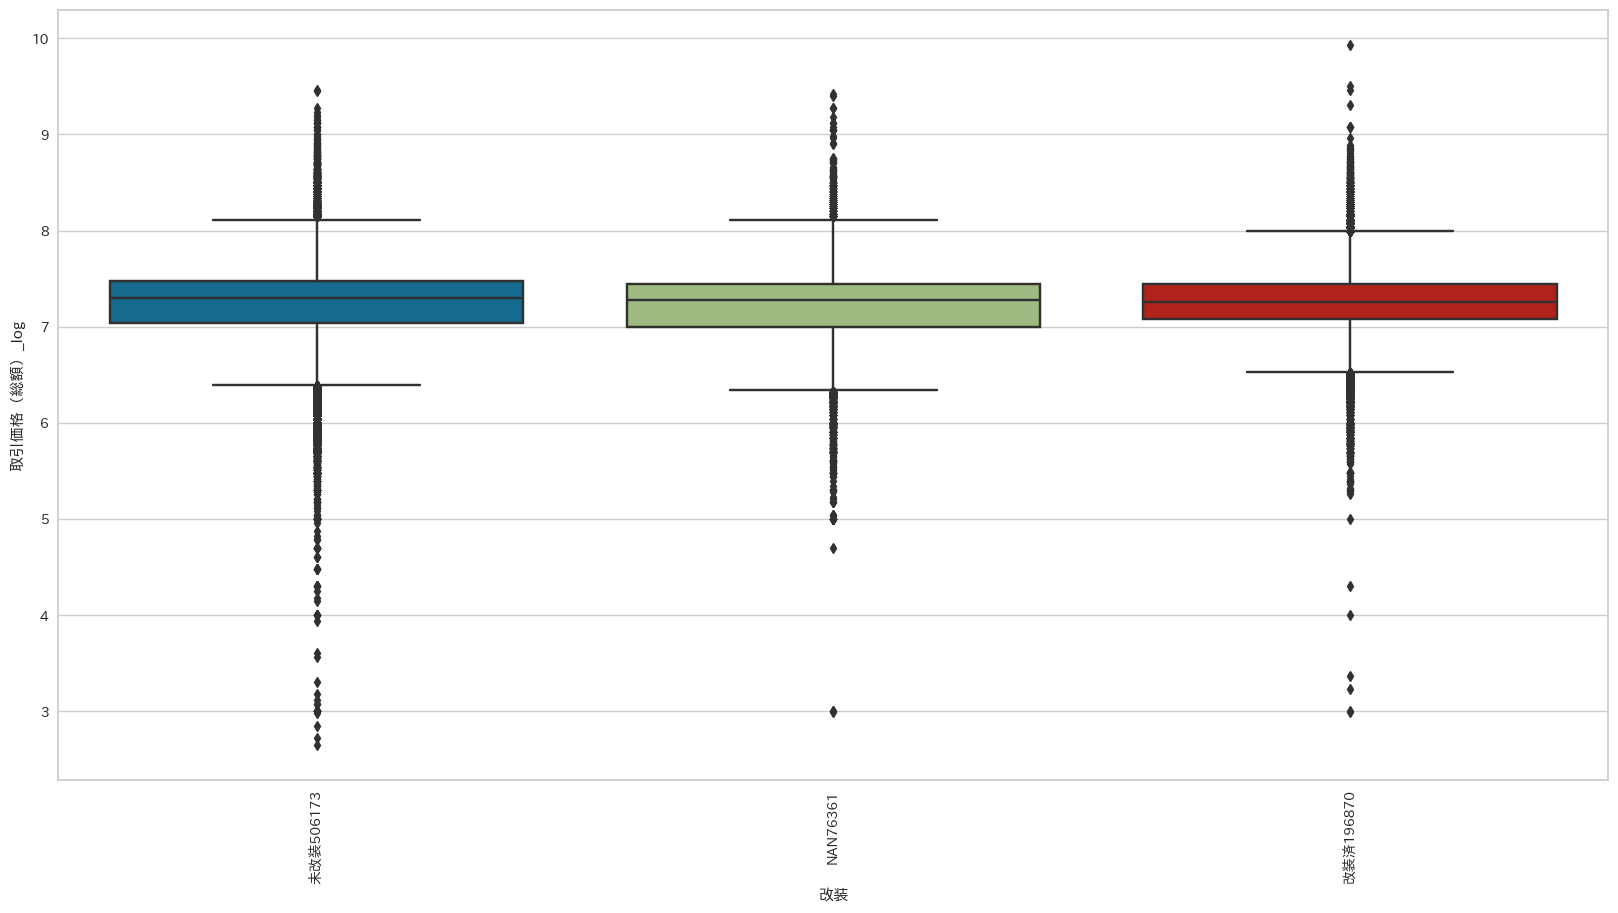

In [12]:
plot_feature_and_price(train_df, "改装")

### 取引時点の各要素における取引価格（総額）_logの分布を箱ひげ図で表示

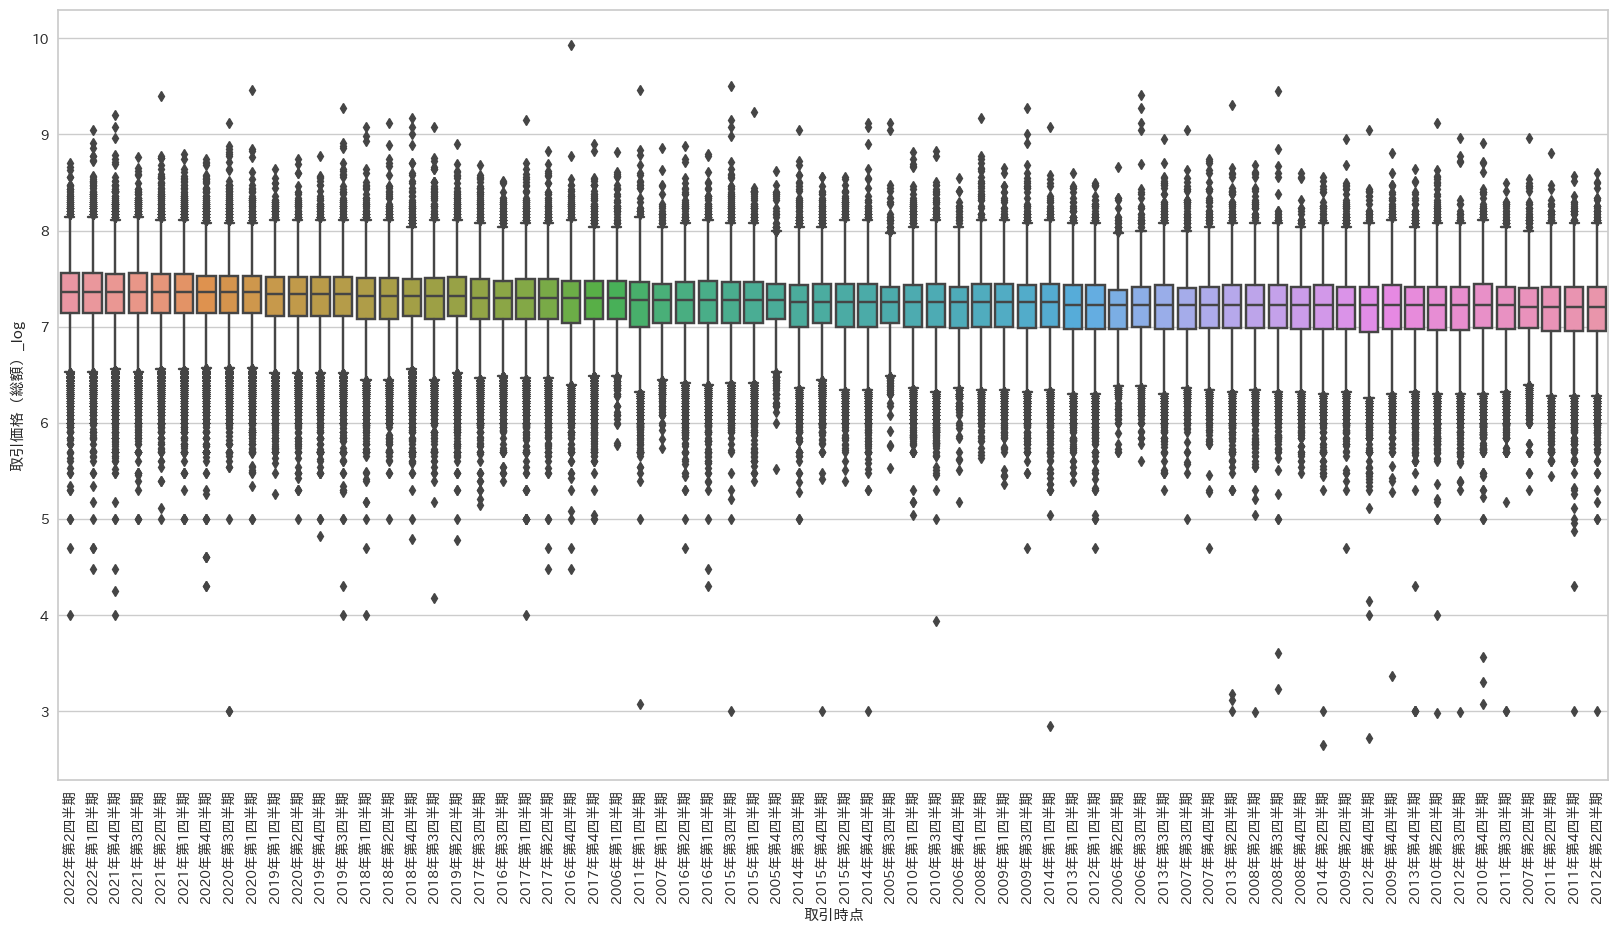

In [78]:
# 取引時点の各要素における取引価格（総額）_logの分布を箱ひげ図で表示
plt.figure(figsize=(20, 10))
df_tmp = train_df.copy()
index = df_tmp.groupby('取引時点').median().sort_values('取引価格（総額）_log', ascending=False).reset_index()['取引時点'].unique()
sns.boxplot(x='取引時点', y='取引価格（総額）_log', data=df_tmp, order=index)
plt.xticks(rotation=90)
plt.show()

### 各年毎の価格

2005 7.23791338539442
2006 7.210634163764768
2007 7.19266477186093
2008 7.192966267779115
2009 7.191791297514197
2010 7.194883728160941
2011 7.184101336588145
2012 7.171392382008477
2013 7.185547212886681
2014 7.201813067090821
2015 7.225806317844335
2016 7.2416532148474735
2017 7.256880688869742
2018 7.273403401767973
2019 7.287143012535339
2020 7.301923645243668
2021 7.319313615514816
2022 7.332689072621443


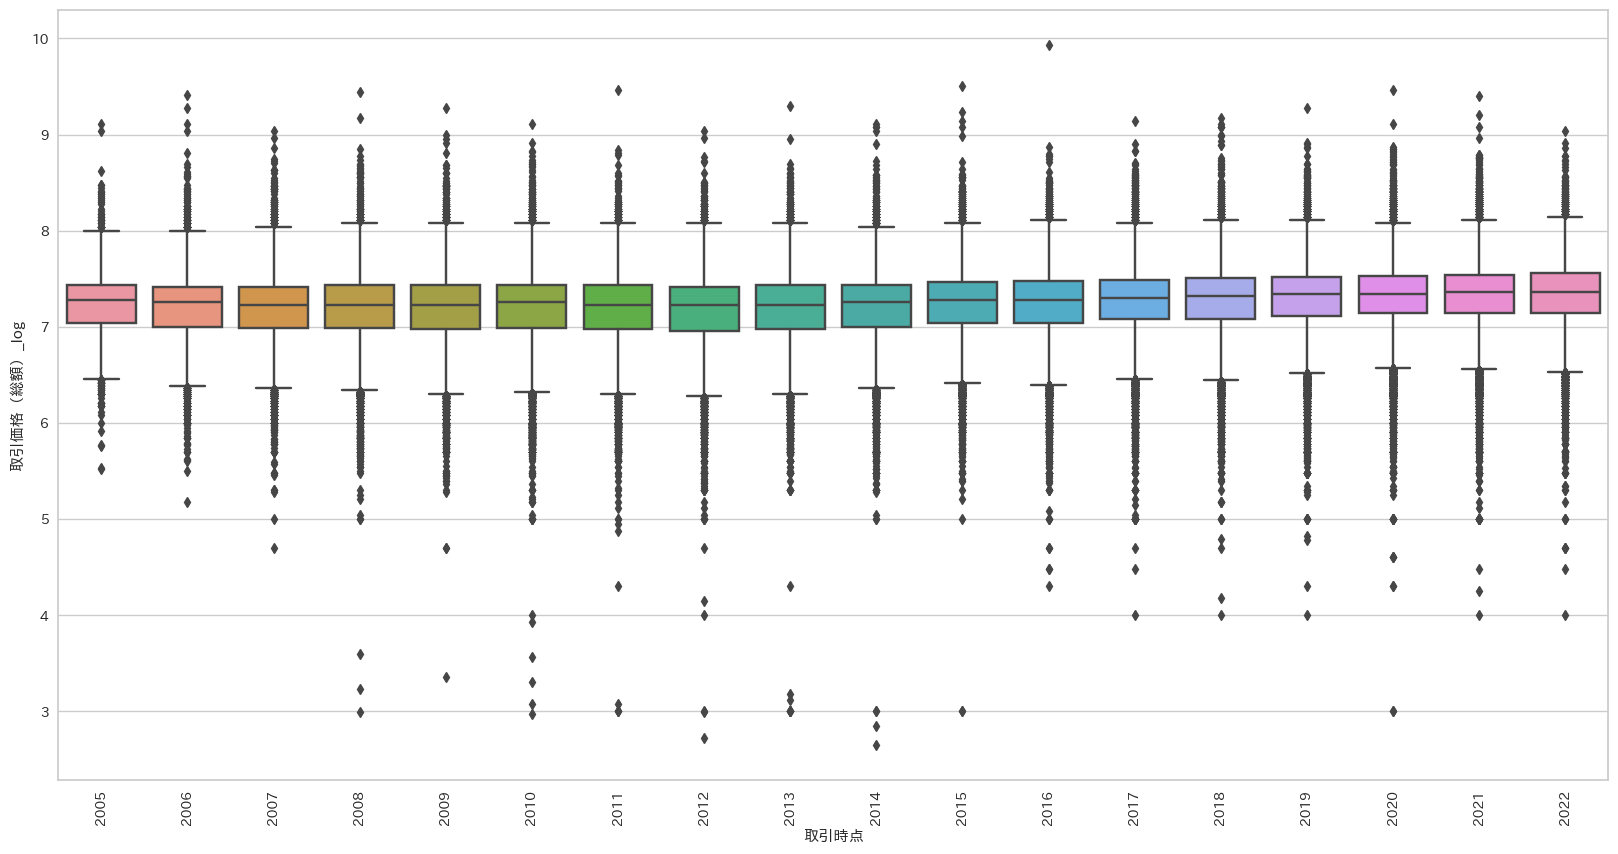

In [88]:
# 取引時点を第一四半期、第二四半期、第三四半期、第四四半期ごとに分けて、取引価格（総額）_logの分布を箱ひげ図で表示
plt.figure(figsize=(20, 10))
df_tmp = train_df.copy()
df_tmp['取引時点'] = df_tmp['取引時点'].apply(lambda x: x.split('年')[0])
index = df_tmp['取引時点'].unique()
# indexを辞書順に並び替え
index = sorted(index, key=lambda x: int(x.split('年')[0]))
sns.boxplot(x='取引時点', y='取引価格（総額）_log', data=df_tmp, order=index)
# それぞれの中央値をprint
for i in range(len(index)):
    print(index[i], df_tmp[df_tmp['取引時点'] == index[i]]['取引価格（総額）_log'].mean())

plt.xticks(rotation=90)
plt.show()

### 第一四半期、第二四半期、第三四半期、第四四半期ごとで箱ひげ図を作成

第1四半期 7.248372992177189
第2四半期 7.2305504758767
第3四半期 7.233037632814044
第4四半期 7.228331560564081


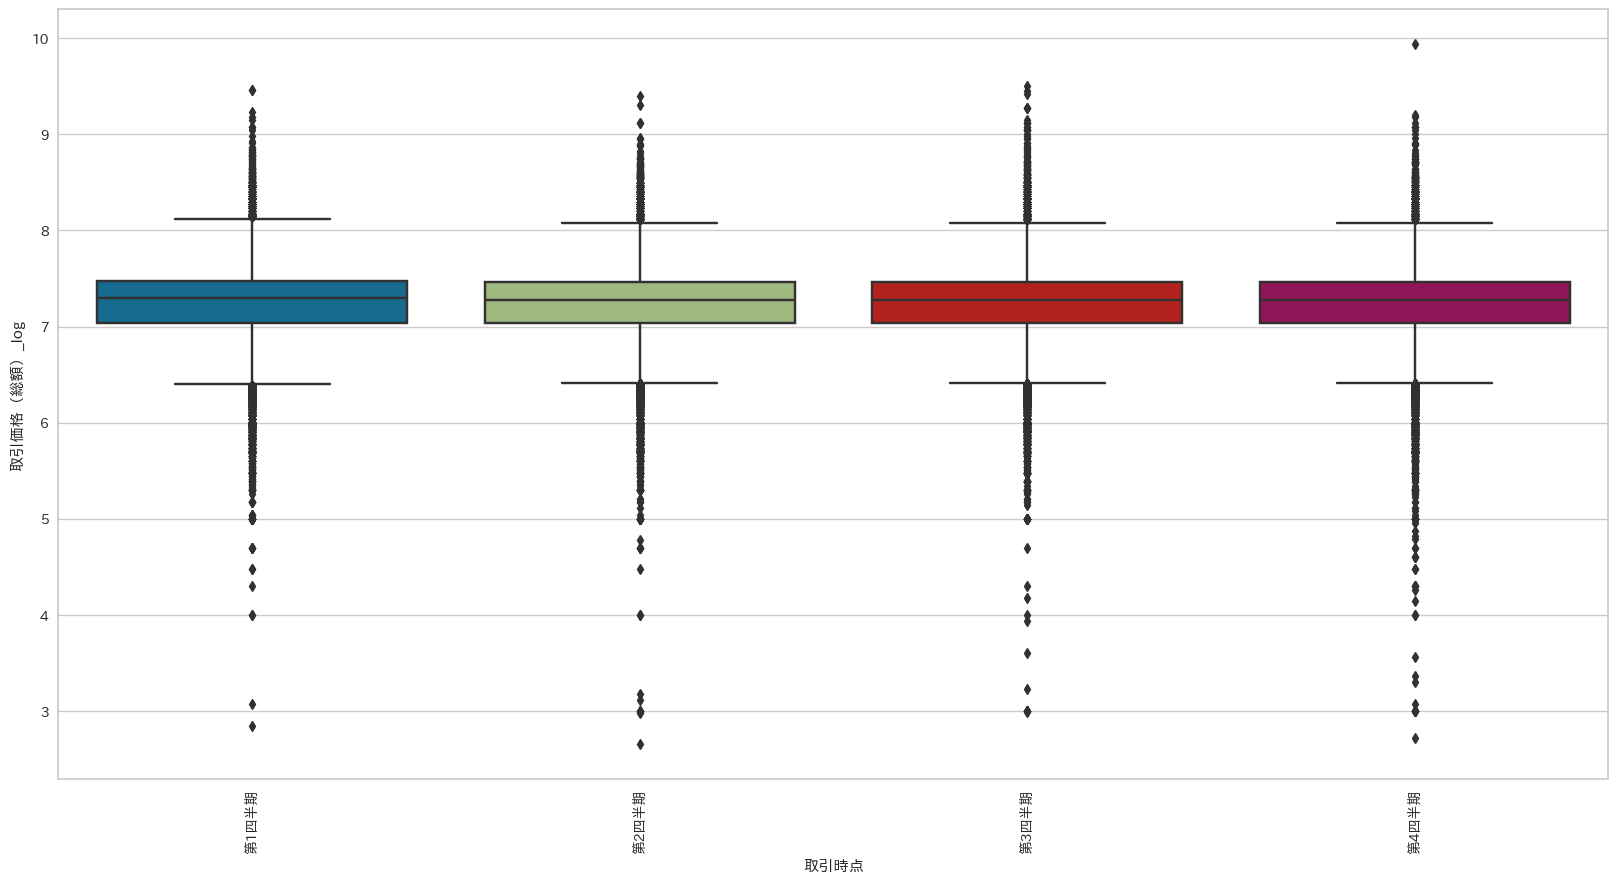

In [85]:
# 取引時点を第一四半期、第二四半期、第三四半期、第四四半期ごとに分けて、取引価格（総額）_logの分布を箱ひげ図で表示
plt.figure(figsize=(20, 10))
df_tmp = train_df.copy()
# df_tmp['取引時点'].value_counts()
df_tmp['取引時点'] = df_tmp['取引時点'].apply(lambda x: x.split('年')[1])
index = ['第1四半期', '第2四半期', '第3四半期', '第4四半期']
sns.boxplot(x='取引時点', y='取引価格（総額）_log', data=df_tmp, order=index)
# それぞれの中央値をprint
for i in range(len(index)):
    print(index[i], df_tmp[df_tmp['取引時点'] == index[i]]['取引価格（総額）_log'].mean())

plt.xticks(rotation=90)
plt.show()

### 用途の各要素における取引価格（総額）_logの分布を箱ひげ図で表示

店舗、その他 2 8.278151250383644
作業場 3 7.778151250383644
住宅、倉庫 1 7.740362689494244
事務所、倉庫 2 7.565166884247503
住宅、事務所、駐車場、店舗 1 7.505149978319906
住宅、駐車場 9 7.477121254719663
事務所、作業場 1 7.342422680822207
住宅、事務所 42 7.340620618687794
工場 8 7.322711134674546
NAN 85676 7.322219294733919
住宅 685315 7.278753600952829
事務所、店舗 81 7.255272505103306
住宅、その他 19 7.230448921378274
店舗 3146 7.146128035678238
倉庫、店舗 4 7.061599037515999
住宅、店舗 59 7.041392685158225
事務所、駐車場 1 6.939519252618618
住宅、店舗、その他 1 6.903089986991944
事務所 3942 6.892094602690481
その他 894 6.845098040014257
駐車場、店舗 2 6.84089188323394
倉庫、駐車場 3 6.812913356642856
倉庫 65 6.6020599913279625
駐車場 127 6.491361693834273
['住宅' 'NAN' '事務所' '店舗' 'その他' '事務所、店舗' '住宅、事務所' '住宅、店舗' '駐車場、店舗' '駐車場'
 '店舗、その他' '住宅、駐車場' '住宅、その他' '倉庫' '住宅、事務所、駐車場、店舗' '倉庫、駐車場' '倉庫、店舗'
 '事務所、作業場' '工場' '住宅、店舗、その他' '作業場' '事務所、倉庫' '住宅、倉庫' '事務所、駐車場']


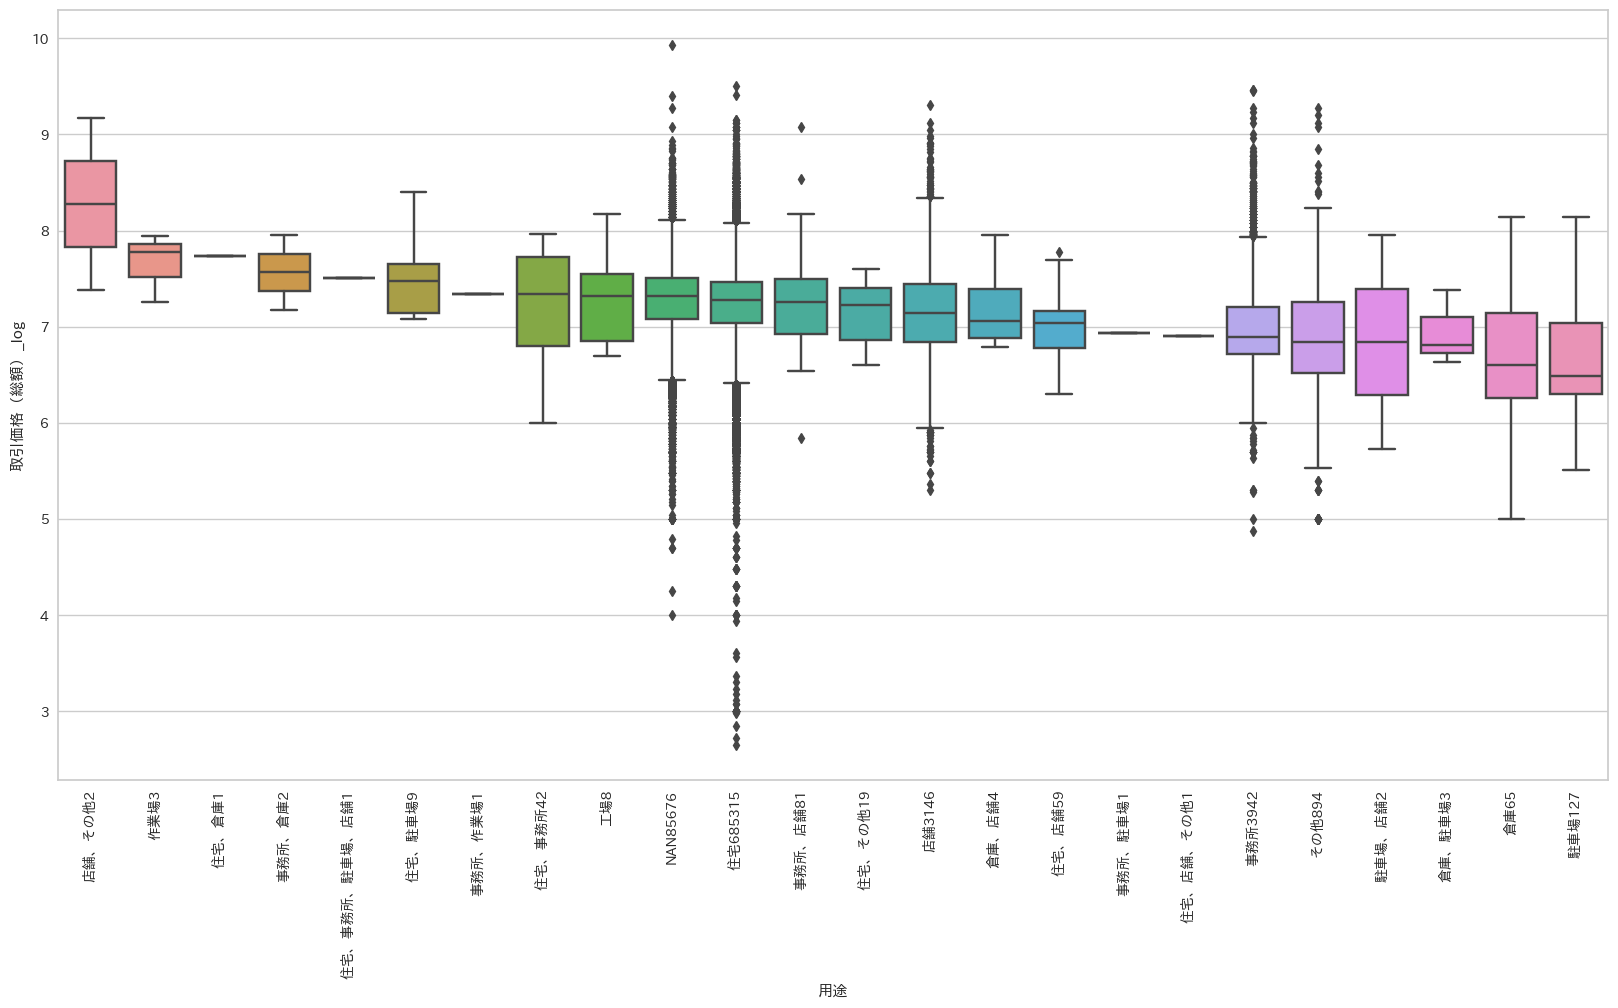

In [49]:
# 用途の各要素における取引価格（総額）_logの分布を箱ひげ図で表示、nanはその他に分類
plt.figure(figsize=(20, 10))
df_tmp = train_df.fillna('NAN').copy()
index = df_tmp.groupby('用途').median().sort_values('取引価格（総額）_log', ascending=False).reset_index()['用途'].unique()
sns.boxplot(x='用途', y='取引価格（総額）_log', data=df_tmp, order=index)
# x軸の各値を変更
plt.xticks(np.arange(len(df_tmp['用途'].unique())), [x + str(df_tmp[df_tmp['用途'] == x].shape[0]) for x in index])
# 横軸の値を回転
plt.xticks(rotation=90)
# 各要素のデータ数を出力
for x in index:
    print(x, df_tmp[df_tmp['用途'] == x].shape[0], np.median(df_tmp[df_tmp['用途'] == x]['取引価格（総額）_log']))
print(df_tmp['用途'].unique())
plt.show()

### 都市計画と価格の関係

工業専用地域 263 7.5910646070264995
第２種低層住居専用地域 1072 7.4623979978989565
第１種低層住居専用地域 23587 7.361727836017593
準都市計画区域 7 7.342422680822207
準工業地域 89312 7.342422680822207
工業地域 19533 7.322219294733919
近隣商業地域 79123 7.301029995663981
第２種住居地域 36019 7.301029995663981
準住居地域 15464 7.301029995663981
商業地域 214678 7.301029995663981
第２種中高層住居専用地域 35364 7.230448921378274
NAN 20670 7.230448921378274
第１種住居地域 118345 7.230448921378274
第１種中高層住居専用地域 120516 7.230448921378274
市街化区域及び市街化調整区域外の都市計画区域 349 6.929418925714293
市街化調整区域 4844 6.892094602690481
都市計画区域外 258 6.278753600952829
['第２種住居地域' '商業地域' '第１種住居地域' '近隣商業地域' '第１種中高層住居専用地域' '準工業地域' '工業地域' 'NAN'
 '第１種低層住居専用地域' '第２種中高層住居専用地域' '準住居地域' '市街化調整区域' '第２種低層住居専用地域' '工業専用地域'
 '市街化区域及び市街化調整区域外の都市計画区域' '都市計画区域外' '準都市計画区域']


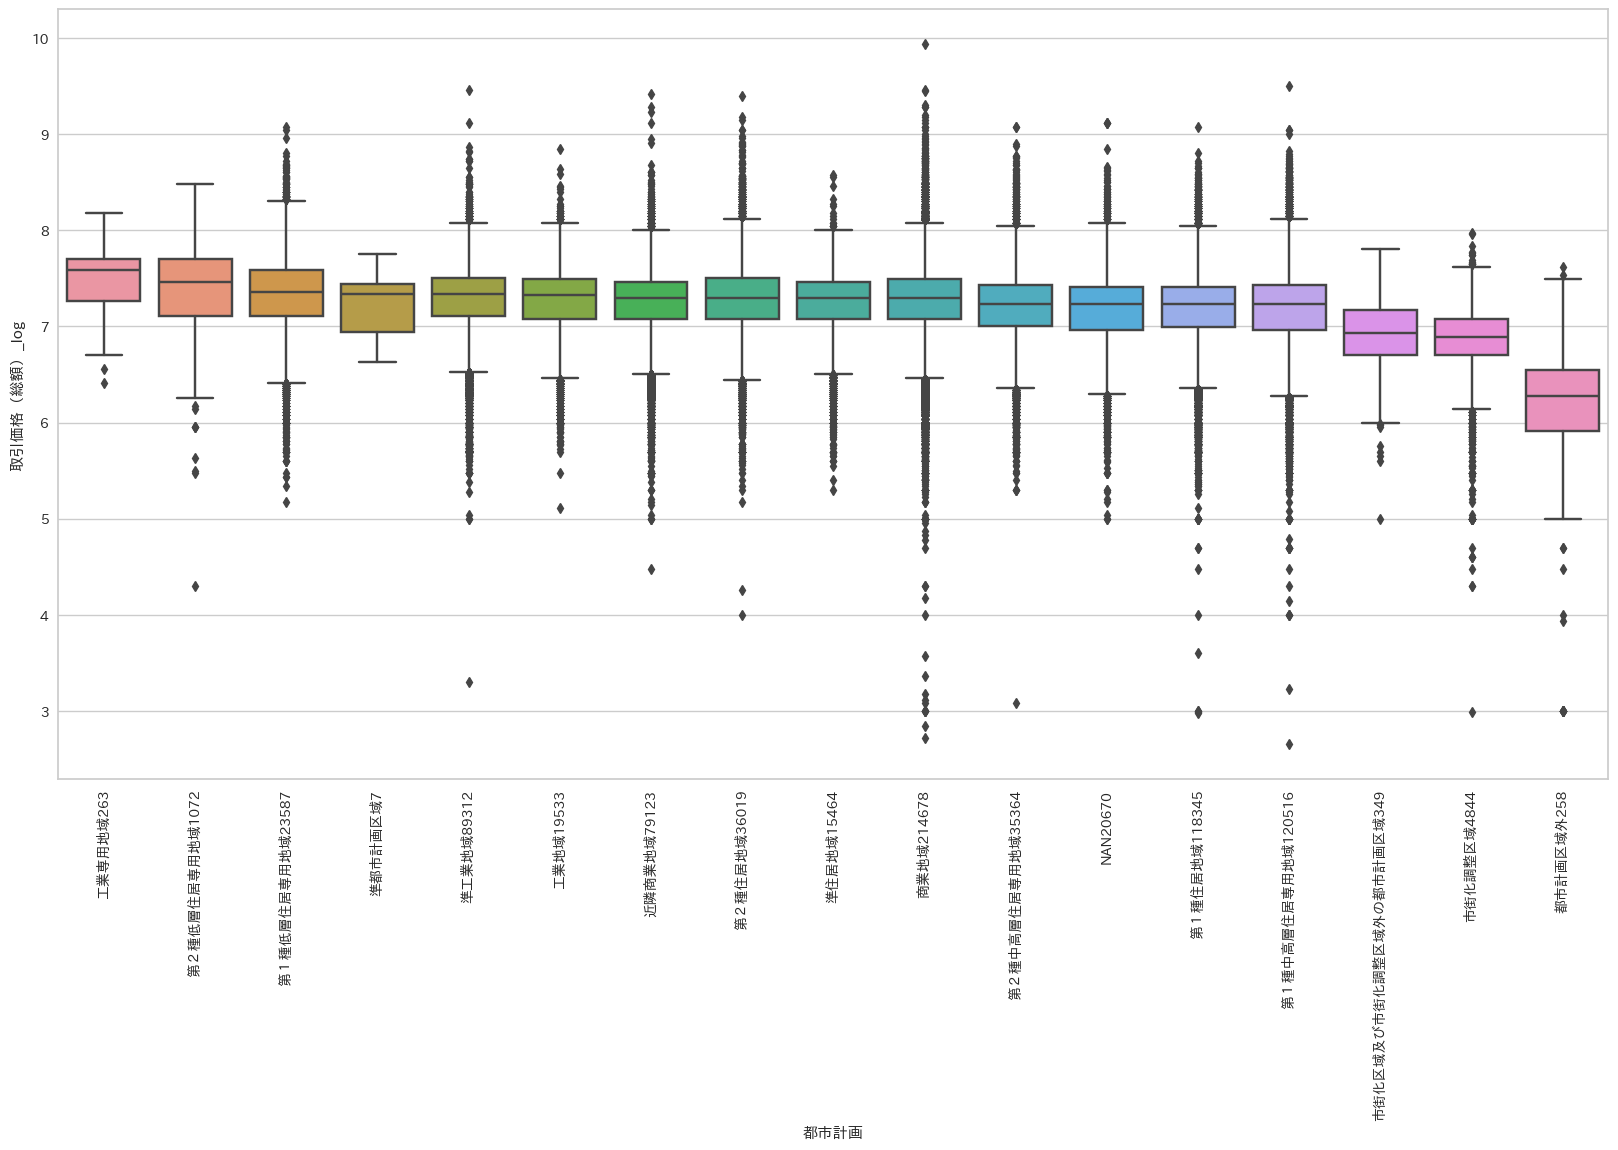

In [48]:
# 都市計画の各要素における取引価格（総額）_logの分布を中央値の大きい順に箱ひげ図で表示
plt.figure(figsize=(20, 10))
df_tmp = train_df.fillna('NAN').copy()
# df_tmpを各都市計画における取引価格（総額）_logの中央値の大きい順にソート
index = df_tmp.groupby('都市計画').median().sort_values('取引価格（総額）_log', ascending=False).reset_index()['都市計画'].unique()
sns.boxplot(x='都市計画', y='取引価格（総額）_log', data=df_tmp, order=index)
# x軸の各値を変更
plt.xticks(np.arange(len(df_tmp['都市計画'].unique())), [x + str(df_tmp[df_tmp['都市計画'] == x].shape[0]) for x in index])
# 横軸の値を回転
plt.xticks(rotation=90)
# 各要素のデータ数を出力
for x in index:
    print(x, df_tmp[df_tmp['都市計画'] == x].shape[0], np.median(df_tmp[df_tmp['都市計画'] == x]['取引価格（総額）_log']))
print(df_tmp['都市計画'].unique())
plt.show()

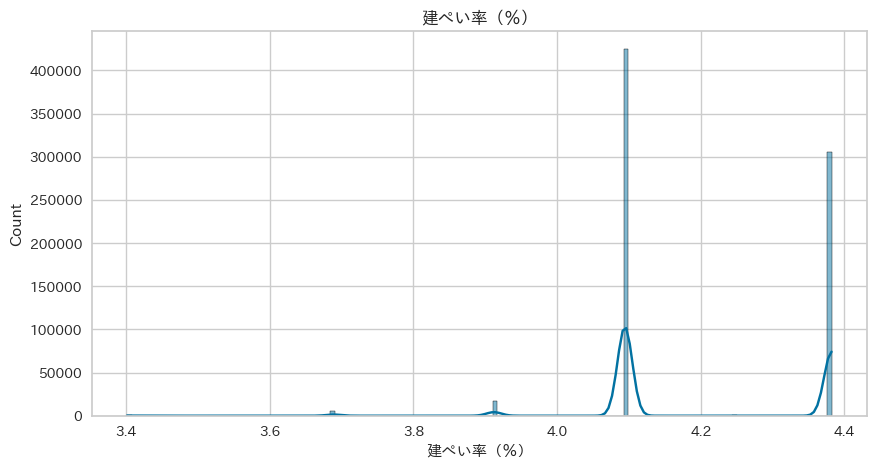

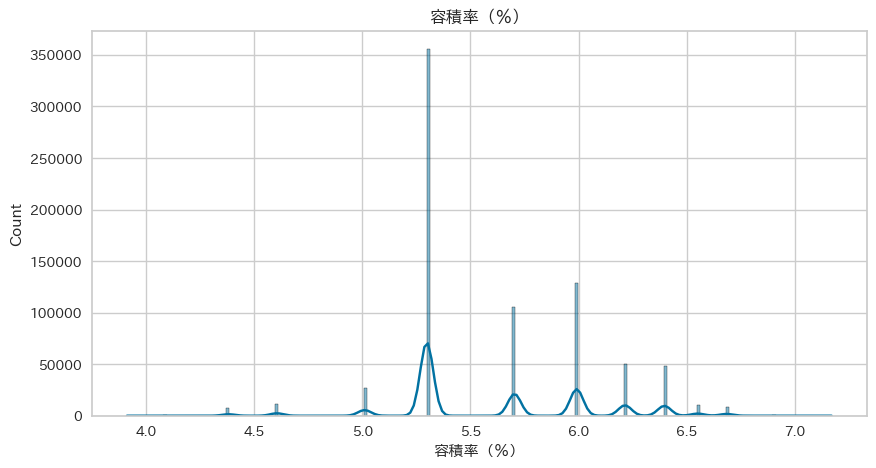

In [9]:
# 数値データに関して、ヒストグラムで分布を確認
for feature in features:
    # train_df[feature]が数値データの場合
    if train_df[feature].dtype != 'object':
        # train_df[feature]がnan以外を含むか確認
        if train_df[feature].isnull().sum() != len(train_df[feature]):
            plt.figure(figsize=(10, 5))
            sns.histplot(np.log(train_df[feature]), kde=True)
            plt.title(feature)
            plt.show()

In [35]:
# Given layout data
layouts = ['４ＬＤＫ', '３ＬＤＫ', '２ＤＫ', 'nan', '１ＤＫ', '２ＬＤＫ',       
           '１ＬＤＫ', '５ＬＤＫ', 'オープンフロア', 
           '１Ｋ', '３ＤＫ', '３ＬＤＫ＋Ｓ', '１Ｒ', '２ＬＤＫ＋Ｓ', '１ＬＤＫ＋Ｓ', '４ＬＤＫ＋Ｓ', '１ＤＫ＋Ｓ', 
           '５ＬＤＫ＋Ｓ', '３Ｋ', '２Ｋ', '２Ｌ', '４ＤＫ', '３ＬＫ', '３ＬＤ', '１Ｌ', '２ＬＫ', 'メゾネット', 
           '２ＤＫ＋Ｓ', '４Ｋ', '３ＤＫ＋Ｓ', '５ＤＫ', '４Ｌ＋Ｋ', '１ＬＫ', '２ＬＤＫ＋Ｋ', '１ＤＫ＋Ｋ', '３Ｋ＋Ｓ', 
           '２Ｋ＋Ｓ', '４ＤＫ＋Ｓ', '２ＬＤ＋Ｓ', '６ＬＤＫ', '１Ｒ＋Ｓ', '４ＬＤＫ＋Ｋ', '３ＬＤＫ＋Ｋ', '２ＬＫ＋Ｓ', 
           '３Ｄ', '６ＬＤＫ＋Ｓ', '７ＬＤＫ', '５Ｋ', '４Ｄ', '１ＬＤ＋Ｓ', 'スタジオ', '１Ｋ＋Ｓ', '２Ｄ', '６ＤＫ', 
           '１Ｌ＋Ｓ', '２Ｌ＋Ｓ', '３ＬＤ＋Ｓ', '１ＬＫ＋Ｓ', '１ＬＤＫ＋Ｋ', '２ＬＤ', '５ＬＤＫ＋Ｋ', '８ＬＤＫ', 
           '４Ｌ', '８ＬＤＫ＋Ｓ', '７ＬＤＫ＋Ｓ', '３ＬＫ＋Ｓ', '７ＤＫ']

# 部屋数を抽出
arrangements = {"ＬＤＫ": "LDK", "ＬＤ": "LDK", "Ｌ": "LDK", "ＤＫ": "DK", "ＬＫ": "DK", "Ｄ": "DK", "Ｋ": "K", "Ｒ": "R"}
for layout in layouts:
    num_rooms = 1
    service_room = 0
    kitchen = 0
    # 一文字目が数字の場合
    if layout[0].isdigit():
        # 最初の一文字と、"＋"以降の文字を削除
        arrangement_type = layout[1:].split('＋')[0]
        arrangement = arrangements[arrangement_type]
        # 部屋数を抽出
        num_rooms = int(layout[0])
        if 'Ｓ' in layout:
            service_room = 1
        if layout[-1] == 'Ｋ':
            kitchen = 1
    else:
        arrangement = layout
    print(layout, ":", arrangement, num_rooms, service_room, kitchen)


# 部屋タイプをLDK, DK, K, 1R, メゾネット, スタジオ, オープンフロアに分類


４ＬＤＫ : LDK 4 0 1
３ＬＤＫ : LDK 3 0 1
２ＤＫ : DK 2 0 1
nan : nan 1 0 0
１ＤＫ : DK 1 0 1
２ＬＤＫ : LDK 2 0 1
１ＬＤＫ : LDK 1 0 1
５ＬＤＫ : LDK 5 0 1
オープンフロア : オープンフロア 1 0 0
１Ｋ : K 1 0 1
３ＤＫ : DK 3 0 1
３ＬＤＫ＋Ｓ : LDK 3 1 0
１Ｒ : R 1 0 0
２ＬＤＫ＋Ｓ : LDK 2 1 0
１ＬＤＫ＋Ｓ : LDK 1 1 0
４ＬＤＫ＋Ｓ : LDK 4 1 0
１ＤＫ＋Ｓ : DK 1 1 0
５ＬＤＫ＋Ｓ : LDK 5 1 0
３Ｋ : K 3 0 1
２Ｋ : K 2 0 1
２Ｌ : LDK 2 0 0
４ＤＫ : DK 4 0 1
３ＬＫ : DK 3 0 1
３ＬＤ : LDK 3 0 0
１Ｌ : LDK 1 0 0
２ＬＫ : DK 2 0 1
メゾネット : メゾネット 1 0 0
２ＤＫ＋Ｓ : DK 2 1 0
４Ｋ : K 4 0 1
３ＤＫ＋Ｓ : DK 3 1 0
５ＤＫ : DK 5 0 1
４Ｌ＋Ｋ : LDK 4 0 1
１ＬＫ : DK 1 0 1
２ＬＤＫ＋Ｋ : LDK 2 0 1
１ＤＫ＋Ｋ : DK 1 0 1
３Ｋ＋Ｓ : K 3 1 0
２Ｋ＋Ｓ : K 2 1 0
４ＤＫ＋Ｓ : DK 4 1 0
２ＬＤ＋Ｓ : LDK 2 1 0
６ＬＤＫ : LDK 6 0 1
１Ｒ＋Ｓ : R 1 1 0
４ＬＤＫ＋Ｋ : LDK 4 0 1
３ＬＤＫ＋Ｋ : LDK 3 0 1
２ＬＫ＋Ｓ : DK 2 1 0
３Ｄ : DK 3 0 0
６ＬＤＫ＋Ｓ : LDK 6 1 0
７ＬＤＫ : LDK 7 0 1
５Ｋ : K 5 0 1
４Ｄ : DK 4 0 0
１ＬＤ＋Ｓ : LDK 1 1 0
スタジオ : スタジオ 1 0 0
１Ｋ＋Ｓ : K 1 1 0
２Ｄ : DK 2 0 0
６ＤＫ : DK 6 0 1
１Ｌ＋Ｓ : LDK 1 1 0
２Ｌ＋Ｓ : LDK 2 1 0
３ＬＤ＋Ｓ : LDK 3 1 0
１ＬＫ＋Ｓ : DK 1 1 0
１ＬＤＫ＋Ｋ : LDK 1 0 1
２ＬＤ : LDK 2 0 0
５ＬＤＫ＋Ｋ : LDK

In [38]:
print(train_df['間取り'].unique().tolist())
def get_arrangement(layout):
    arrangements = {"ＬＤＫ": "LDK", "ＬＤ": "LDK", "Ｌ": "LDK", "ＤＫ": "DK", "ＬＫ": "DK", "Ｄ": "DK", "Ｋ": "K", "Ｒ": "R"}
    num_rooms = 1
    service_room = 0
    kitchen = 0
    if isinstance(layout, str):
        # 一文字目が数字の場合
        if layout[0].isdigit():
            # 最初の一文字と、"＋"以降の文字を削除
            arrangement_type = layout[1:].split('＋')[0]
            arrangement = arrangements[arrangement_type]
            # 部屋数を抽出
            num_rooms = int(layout[0])
            if 'Ｓ' in layout:
                service_room = 1
            if '＋Ｋ' in layout:
                kitchen = 1
        else:
            arrangement = layout
    else:
        arrangement = layout
    return arrangement, num_rooms, service_room, kitchen
train_df[['部屋タイプ', '部屋数', 'サービスルーム', 'キッチン']] = train_df['間取り'].apply(get_arrangement).apply(pd.Series)

['２ＬＤＫ', '３ＬＤＫ', '１Ｋ', '４ＬＤＫ', '２ＤＫ', '１ＬＤＫ', '１Ｒ', nan, 'オープンフロア', '１ＤＫ', '５ＬＤＫ', '６ＤＫ', '４ＤＫ', '２Ｋ', '３ＤＫ', '３ＬＤＫ＋Ｓ', '２ＬＤＫ＋Ｓ', '１Ｋ＋Ｓ', '５ＤＫ', '１ＬＤＫ＋Ｓ', '４Ｋ', '３Ｋ', '４ＬＤＫ＋Ｓ', '１ＬＫ', '６ＬＤＫ', '１ＤＫ＋Ｓ', '１Ｒ＋Ｓ', '４Ｌ＋Ｋ', '６ＬＤＫ＋Ｓ', '４ＤＫ＋Ｓ', '２ＤＫ＋Ｓ', '３ＤＫ＋Ｓ', 'スタジオ', '３Ｄ', '７ＬＤＫ', '５ＬＤＫ＋Ｓ', '３ＬＫ＋Ｓ', '７ＤＫ', '３ＬＫ', '５Ｋ', '２Ｋ＋Ｓ', '８ＬＤＫ', '２ＬＫ', '１Ｌ', '２ＬＫ＋Ｓ', '３ＬＤ', '３ＬＤＫ＋Ｋ', '２ＬＤ＋Ｓ', '４ＬＤＫ＋Ｋ', 'メゾネット', '２Ｌ', '３ＬＤ＋Ｓ', '４Ｌ', '８ＬＤＫ＋Ｓ', '７ＬＤＫ＋Ｓ', '２ＬＤＫ＋Ｋ', '５ＬＤＫ＋Ｋ', '１ＬＤ＋Ｓ', '２Ｌ＋Ｓ', '１ＤＫ＋Ｋ', '３Ｋ＋Ｓ', '２Ｄ', '１Ｌ＋Ｓ', '１ＬＫ＋Ｓ', '１ＬＤＫ＋Ｋ', '２ＬＤ', '４Ｄ']


,0,1,2,3
0,LDK,2.0,0.0,1.0
1,LDK,3.0,0.0,1.0
2,LDK,2.0,0.0,1.0
3,LDK,3.0,0.0,1.0
4,LDK,2.0,0.0,1.0
...,...,...,...,...
779399,LDK,2.0,0.0,1.0
779400,LDK,3.0,0.0,1.0
779401,LDK,3.0,0.0,1.0
779402,LDK,1.0,0.0,1.0


In [30]:
train_df_2LDK_S = train_df[train_df['間取り'] == nan]
train_df_2LDK_S.head()


,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,建築年,建物の構造,用途,今後の利用目的,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引の事情等,取引価格（総額）_log


In [34]:
# 間取りがnanのデータを表示
print(train_df[train_df['間取り'].isnull()]['用途'].unique())
train_df[train_df['間取り'].isnull()].head()


['住宅' 'その他' nan '事務所' '店舗' '駐車場' '店舗、その他' '事務所、店舗' '住宅、店舗' '倉庫' '倉庫、駐車場'
 '住宅、事務所' '住宅、その他' '倉庫、店舗' '住宅、駐車場' '工場' '作業場']


,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,建築年,建物の構造,用途,今後の利用目的,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引の事情等,取引価格（総額）_log
45,大橋(福岡),8,NaN,80,昭和60年,ＲＣ,住宅,住宅,第１種住居地域,60.0,200.0,2016年第2四半期,NaN,NaN,7.301030
57,竹下,24,NaN,50,平成6年,ＲＣ,住宅,NaN,工業地域,60.0,200.0,2014年第1四半期,改装済,NaN,6.991226
60,姪浜,28,NaN,80,平成2年,ＳＲＣ,住宅,NaN,準工業地域,60.0,200.0,2013年第4四半期,未改装,NaN,7.113943
87,NaN,NaN,NaN,50,NaN,ＲＣ,住宅,NaN,NaN,NaN,NaN,2008年第4四半期,NaN,調停・競売等,6.301030
93,大濠公園,6,NaN,45,昭和60年,ＳＲＣ,住宅,NaN,商業地域,80.0,400.0,2006年第4四半期,未改装,NaN,6.845098


In [23]:
import pandas as pd
from sklearn.model_selection import KFold
from xfeat import TargetEncoder
df = pd.DataFrame({
    "col": ["A", "A", "A", "B", "B", "B", "B"],
    "target": [1, 1, 0, 1, 1, 1, 0],
})
fold = KFold(n_splits=2, shuffle=False)
# dfをfoldで分割
for trn_idx, val_idx in fold.split(df):
    print(trn_idx, val_idx)

encoder = TargetEncoder(fold=fold)
encoder.fit_transform(df)

[4 5 6] [0 1 2 3]
[0 1 2 3] [4 5 6]


,col,target,col_te
0,A,1,0.000000
1,A,1,0.000000
2,A,0,0.000000
3,B,1,0.666667
4,B,1,1.000000
5,B,1,1.000000
6,B,0,1.000000
